<frozen importlib._bootstrap>:241: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


Q-table shape: (20736, 8)


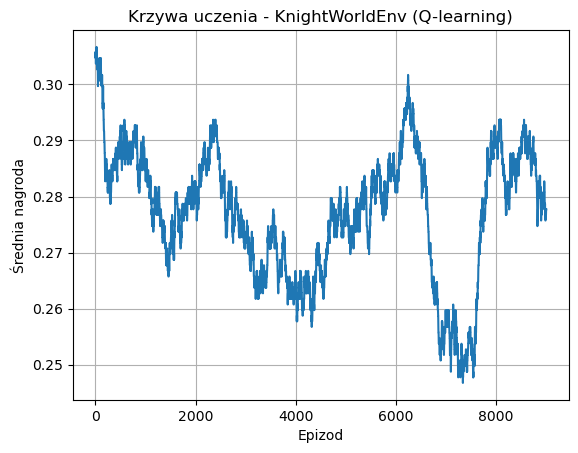

In [1]:
import gymnasium
import gymnasium_env
from gymnasium.wrappers import FlattenObservation
import matplotlib.pyplot as plt
import numpy as np

env = gymnasium.make('gymnasium_env/KnightWorldEnv-v0', size=12)

alpha = 0.1
gamma = 0.9
epsilon = 0.9
episodes = 10000
max_steps = 100
epsilon_decay = 0.999

# Since the observation space is a Dict, we need to flatten it for Q-learning
wrapped_env = FlattenObservation(env)
env = wrapped_env  # Use the wrapped environment for training

# The observation space is flattened to [agent_y, agent_x, target_y, target_x]
# We need a function to map these to discrete state indices
def state_to_index(state):
    # For a 12x12 grid, we need to encode agent and target positions
    agent_pos = state[0] * 12 + state[1]  # agent y*width + x
    target_pos = state[2] * 12 + state[3]  # target y*width + x
    # Create a unique index based on both positions
    # There are at most 12x12=144 possible positions for each
    return int(agent_pos * 144 + target_pos)

# Define state space size based on the maximum possible index
state_space_size = 144 * 144  # 12x12 grid positions for both agent and target
action_space_size = env.action_space.n

# Create Q-table
Q = np.zeros((state_space_size, action_space_size))
print(f"Q-table shape: {Q.shape}")
rewards = []

for episode in range(episodes):
    obs, _ = env.reset()
    state_idx = state_to_index(obs)
    total_reward = 0

    for step in range(max_steps):
        # Epsilon-greedy action selection
        if np.random.rand() < epsilon:
            action = env.action_space.sample()
        else:
            action = np.argmax(Q[state_idx])

        next_obs, reward, terminated, truncated, _ = env.step(action)
        next_state_idx = state_to_index(next_obs)
        done = terminated or truncated

        # Q-learning update
        old_value = Q[state_idx, action]
        next_max = np.max(Q[next_state_idx])
        Q[state_idx, action] = old_value + alpha * (reward + gamma * next_max - old_value)

        state_idx = next_state_idx
        total_reward += reward

        if done:
            break
            
    if epsilon > 0.01:
        epsilon *= epsilon_decay

    rewards.append(total_reward)

window = 1000
if len(rewards) > window:
    avg_rewards = [np.mean(rewards[i-window:i+1]) for i in range(window, len(rewards))]

    plt.plot(avg_rewards)
    plt.title("Krzywa uczenia - KnightWorldEnv (Q-learning)")
    plt.xlabel("Epizod")
    plt.ylabel("Średnia nagroda")
    plt.grid(True)
    plt.show()
else:
    print("Not enough episodes to calculate average rewards.")

np.save("Q_table.npy", Q)
# Save the size parameter for visualization
np.save("grid_size.npy", np.array([12]))